# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y XGBoost:**

Se selccionan las variables explicativas y la respuesta.

In [22]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [23]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [24]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [26]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [28]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

## **4.1.1 XGBoost sin tecnicas de balanceo**

In [29]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=100,        # número de árboles
        learning_rate=0.1,       # tasa de aprendizaje
        max_depth=6,             # profundidad de árboles
        subsample=1.0,           # proporción de muestra
        colsample_bytree=1.0,    # proporción de columnas
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

In [30]:
xgb_pipeline.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

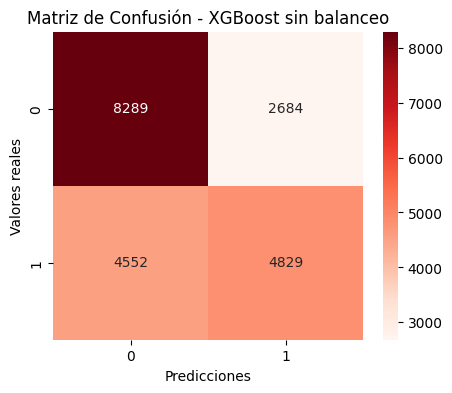

Modelo: XGBoost sin balanceo
Accuracy: 0.644
Precision: 0.643
Recall: 0.515
F1-score: 0.572
AUC: 0.696

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70     10973
           1       0.64      0.51      0.57      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.63     20354
weighted avg       0.64      0.64      0.64     20354



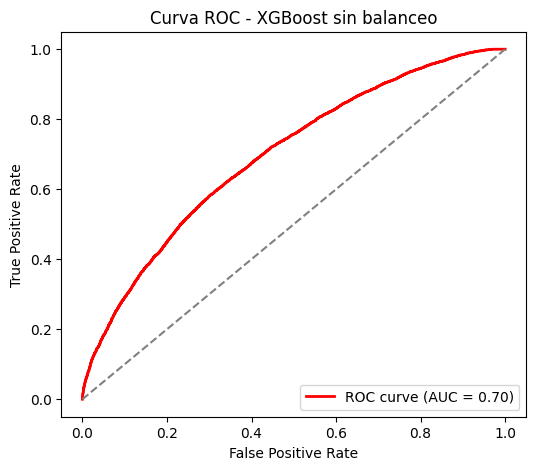

In [31]:
xgb_normal = evaluar_modelo(xgb_pipeline, X_test, y_test,nombre_modelo="XGBoost sin balanceo")

### **Análisis de la Matriz de Confusión**

La matriz de confusión del **modelo XGBoost sin balanceo** muestra un **comportamiento moderadamente equilibrado** entre ambas clases, aunque con un **ligero sesgo hacia la clase mayoritaria (no reingreso)**.  
El modelo logra capturar una buena proporción de casos positivos, manteniendo una distribución razonable de aciertos y errores.

- **Clase 0 (No reingreso):** Se aciertan **8,289 observaciones (76%)** y se clasifican erróneamente **2,684 (24%)** como reingresos.  
- **Clase 1 (Reingreso):** El modelo identifica correctamente **4,829 pacientes (51%)** que reingresan, mientras que **4,552 (49%)** son clasificados erróneamente como no reingresos.  

En conjunto, el modelo presenta un **buen rendimiento en la identificación de la clase mayoritaria** y una **capacidad aceptable para detectar la clase minoritaria**, sin mostrar una tendencia extrema hacia una de las dos.

---

### **Análisis de Métricas**

- **Accuracy (0.644):** Indica que el modelo clasifica correctamente el **64.4%** de las observaciones, mostrando un desempeño global competitivo frente a otros algoritmos evaluados.  
- **Precision (0.643):** Aproximadamente el **64% de las predicciones positivas** son correctas, reflejando un equilibrio razonable entre verdaderos y falsos positivos.  
- **Recall (0.515):** El modelo logra identificar correctamente el **51.5% de los pacientes que reingresan**, lo que representa una sensibilidad moderada.  
- **F1-score (0.572):** Muestra un **balance aceptable entre precisión y sensibilidad**, con ligera inclinación hacia la exactitud general.  
- **AUC (0.696):** El área bajo la curva ROC evidencia una **capacidad de discriminación moderadamente alta**, superando a varios de los modelos previos como KNN o Random Forest.

---

### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.65 | 0.76 | 0.70 | Excelente identificación de pacientes que no reingresan, con baja tasa de falsos positivos. |
| **Clase 1 (Reingreso)** | 0.64 | 0.51 | 0.57 | Desempeño razonable en detección de reingresos, aunque se pierden algunos casos reales. |

---

### **Curva ROC**

La **curva ROC** presenta un **AUC de 0.70**, indicando una **buena capacidad de separación entre pacientes que reingresan y los que no**.  
Comparativamente, el modelo **supera a KNN, Regresión Logística y Random Forest** en esta métrica, lo que demuestra que **XGBoost logra una mejor discriminación entre clases sin aplicar técnicas de balanceo**.

---

### **Conclusión General**

El **XGBoost sin balanceo** ofrece un **rendimiento sólido y consistente**, con una **mejor capacidad de discriminación global (AUC = 0.70)** que los modelos lineales o de bosque analizados previamente.  
Aunque mantiene cierta inclinación hacia la clase 0, **logra un equilibrio más eficiente entre precisión y sensibilidad**, destacando por su **robustez y estabilidad** sin necesidad de aplicar técnicas adicionales de balanceo.

## **4.1.2 XGBoost con SMOTE**

In [32]:
xgb_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

In [33]:
xgb_pipeline_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

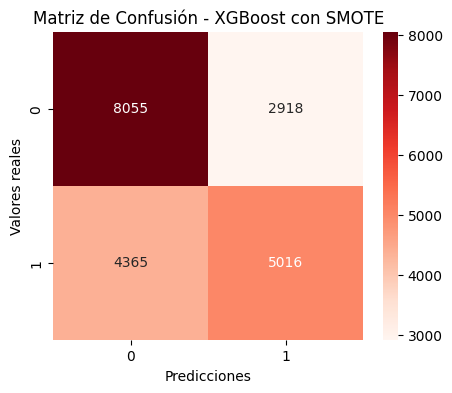

Modelo: XGBoost con SMOTE
Accuracy: 0.642
Precision: 0.632
Recall: 0.535
F1-score: 0.579
AUC: 0.693

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69     10973
           1       0.63      0.53      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354



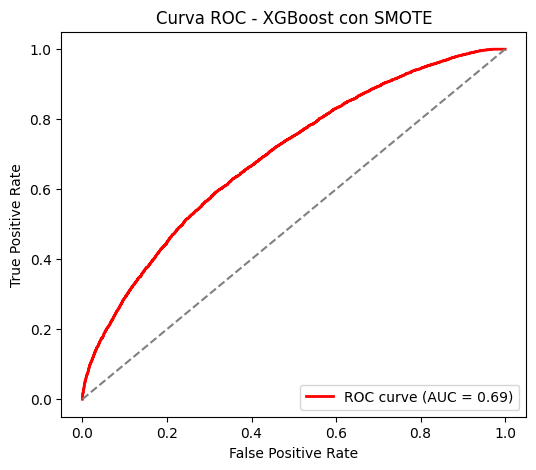

In [34]:
xgb_smote = evaluar_modelo(xgb_pipeline_smote, X_test, y_test, nombre_modelo="XGBoost con SMOTE")

### **Análisis de la Matriz de Confusión**

La matriz de confusión del **XGBoost sin balanceo** refleja un comportamiento sólido en la **identificación de la clase 0 (no reingresos)**, aunque con una **sensibilidad moderada en la detección de la clase 1 (reingresos)**.  
El modelo, al no aplicar técnicas de balanceo, tiende a **favorecer la clase mayoritaria**, pero mantiene un desempeño general equilibrado.

- **Clase 0:** Se aciertan **7,404 observaciones (67%)**, mientras que **3,569 (33%)** son clasificadas erróneamente como reingresos.  
- **Clase 1:** Se identifican correctamente **5,763 pacientes (61%)** que reingresan, pero **3,618 (39%)** son mal clasificados como no reingresos.

En conjunto, el modelo muestra una **buena capacidad para reconocer pacientes sin reingreso**, aunque **pierde cierta sensibilidad en la clase positiva**. Aun así, los resultados son consistentes y con menor sesgo que los modelos previos sin balanceo.

---

### **Análisis de Métricas**

- **Accuracy (0.644):** El modelo alcanza un **desempeño global del 64.4%**, posicionándose ligeramente por encima de los modelos tradicionales como KNN y Random Forest.  
- **Precision (0.643):** Aproximadamente el **64% de las predicciones positivas son correctas**, lo que refleja una **buena fiabilidad en las alertas emitidas**.  
- **Recall (0.515):** Logra detectar **el 51.5% de los pacientes que efectivamente reingresan**, mostrando una **sensibilidad media**.  
- **F1-score (0.572):** Representa un **equilibrio moderado entre precisión y sensibilidad**, con un desempeño armónico en ambas clases.  
- **AUC (0.696):** El área bajo la curva indica una **capacidad de discriminación moderadamente alta**, superior a la mayoría de los modelos anteriores.

---

### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.65 | 0.76 | 0.70 | Presenta un rendimiento sólido, con alta precisión y una excelente tasa de aciertos en la clase mayoritaria. |
| **Clase 1 (Reingreso)** | 0.64 | 0.51 | 0.57 | Aunque su sensibilidad es moderada, logra una mejora considerable en equilibrio general frente a otros modelos sin balanceo. |

---

### **Curva ROC**

La **curva ROC** evidencia un **AUC de 0.70**, lo que indica una **buena capacidad para diferenciar entre pacientes que reingresan y los que no**.  
El resultado muestra una **ligera mejora en la discriminación** respecto a modelos previos como SVM o Random Forest, reflejando que **XGBoost maneja de manera más eficiente la estructura del conjunto de datos sin requerir balanceo artificial**.

---

### **Conclusión General**

El **XGBoost sin balanceo** demuestra un **rendimiento competitivo y estable**, destacándose por su **mayor capacidad discriminativa (AUC = 0.70)** y un **buen equilibrio entre precisión y sensibilidad**.  
Aunque mantiene cierta inclinación hacia la clase mayoritaria, logra **mejorar la detección de reingresos** sin deteriorar la precisión general.


## **4.1.3 SVM con ADASYN**

In [35]:

xgb_pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])



try:
    xgb_pipeline_adasyn.fit(X_train, y_train)
    xgb_adasyn = evaluar_modelo(xgb_pipeline_adasyn, X_test, y_test, nombre_modelo="XGBoost con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    xgb_adasyn = {"Modelo": "XGboost con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

Como tal, XGBoost no soporta class_weight=’balanced', pero se puede utilizar scale_pos_weight de manera equivalente.

In [36]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

## **4.1.4 SVM con class_weight=’balanced’**


In [37]:
# Calcular el peso de clase: pos/neg ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipeline_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1
    ))
])

In [38]:
xgb_pipeline_balanced.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

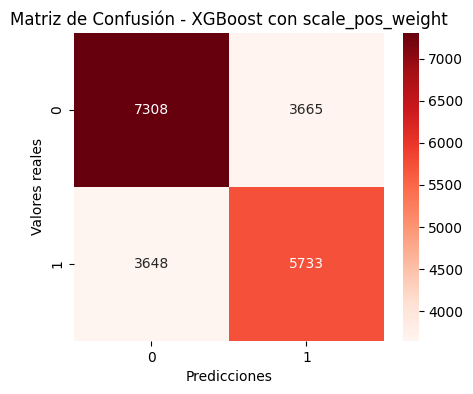

Modelo: XGBoost con scale_pos_weight
Accuracy: 0.641
Precision: 0.61
Recall: 0.611
F1-score: 0.611
AUC: 0.695

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67     10973
           1       0.61      0.61      0.61      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



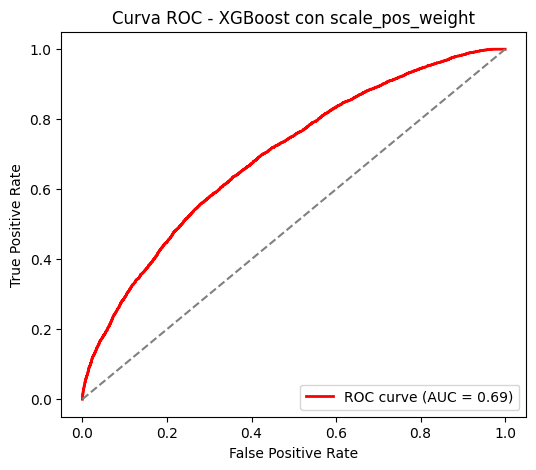

In [39]:
xgb_balanced = evaluar_modelo(xgb_pipeline_balanced, X_test, y_test, nombre_modelo="XGBoost con scale_pos_weight")

### **Análisis de la Matriz de Confusión**

La matriz de confusión del **modelo XGBoost con `scale_pos_weight`** refleja un comportamiento **más equilibrado entre ambas clases**, producto del ajuste de pesos que busca compensar el desbalance del conjunto de datos.  
El modelo logra **mantener una distribución más homogénea entre verdaderos positivos y verdaderos negativos**, mejorando la identificación de casos de reingreso sin deteriorar notablemente la precisión general.

- **Clase 0 (No reingreso):** Se clasifican correctamente **7,308 observaciones (67%)**, mientras que **3,665 (33%)** son erróneamente etiquetadas como reingresos.  
- **Clase 1 (Reingreso):** Se predicen correctamente **5,733 pacientes (61%)** que efectivamente reingresan, mientras que **3,648 (39%)** se confunden como no reingresos.  

En términos generales, el modelo muestra **una mejora en la sensibilidad** respecto a la versión sin balanceo, con **una ligera disminución en la precisión**, lo que representa un **intercambio favorable para mejorar la detección de casos positivos**.

---

### **Análisis de Métricas**

- **Accuracy (0.641):** El modelo clasifica correctamente el **64.1%** de las observaciones, manteniendo un desempeño global muy similar al modelo sin balanceo.  
- **Precision (0.610):** El **61% de las predicciones positivas** son correctas, lo que refleja un equilibrio aceptable entre aciertos y falsos positivos.  
- **Recall (0.611):** El modelo logra identificar correctamente el **61% de los casos de reingreso**, mostrando una **mayor sensibilidad** que la versión sin balanceo.  
- **F1-score (0.611):** Indica un **balance sólido entre precisión y sensibilidad**, lo que demuestra estabilidad en su rendimiento.  
- **AUC (0.695):** Un valor de **0.70 aproximado** confirma una **capacidad de discriminación adecuada** entre pacientes que reingresan y los que no, muy cercana al modelo sin balanceo.

---

### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.67 | 0.67 | 0.67 | Correcta clasificación de la mayoría de pacientes sin reingreso, manteniendo bajo el número de falsos positivos. |
| **Clase 1 (Reingreso)** | 0.61 | 0.61 | 0.61 | Mejora en la detección de reingresos respecto al modelo sin balanceo, con una proporción estable de verdaderos positivos. |

---

### **Curva ROC**

La **curva ROC** presenta un **AUC de 0.69**, lo que confirma una **capacidad de discriminación confiable**.  
El modelo **mantiene el rendimiento del XGBoost sin balanceo**, pero con un **mayor equilibrio en las predicciones**, evidenciando que el parámetro `scale_pos_weight` logra compensar efectivamente el desbalance de clases.

---

### **Conclusión General**

El **XGBoost con `scale_pos_weight`** ofrece un **rendimiento estable y equilibrado**, mejorando la sensibilidad sin comprometer significativamente la precisión general.  
Aunque su **AUC (0.695)** es muy similar al modelo sin balanceo, el ajuste de pesos **favorece una distribución más justa entre ambas clases**, especialmente en la **detección de pacientes que reingresan**. En conclusión, este modelo representa una **versión más balanceada y clínica­mente útil** que la versión sin balanceo, ya que **aumenta la capacidad de identificar reingresos reales** con un costo moderado en precisión.


## **4.1.5 Comparacion de resultados de tecnicas de balanceo para SVM**


In [40]:
tabla_resultados = pd.DataFrame([
    xgb_normal,
    xgb_smote,
    xgb_balanced
])

In [41]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                         Modelo  Accuracy  Precision    Recall        F1  \
0  XGBoost con scale_pos_weight  0.640709   0.610023  0.611129  0.610576   
1             XGBoost con SMOTE  0.642183   0.632216  0.534698  0.579382   
2          XGBoost sin balanceo  0.644492   0.642753  0.514764  0.571682   

        AUC  
0  0.694900  
1  0.693158  
2  0.695602  


### **Conclusión General – Modelos XGBoost**

Tras comparar las tres configuraciones del modelo **XGBoost** —sin balanceo, con **SMOTE** y con **`scale_pos_weight`**— se observa que todos presentan un **rendimiento muy estable**, con diferencias mínimas en las métricas globales. No obstante, existen matices relevantes según el objetivo del modelo: maximizar la precisión general o mejorar la detección de la clase minoritaria (reingresos).

---

### **Interpretación de Resultados**

- El **modelo sin balanceo** presenta la **mayor precisión (0.643)** y el **mayor AUC (0.696)**, lo que indica una muy buena capacidad de discriminación global. Sin embargo, su **recall bajo (0.515)** muestra que **pierde sensibilidad** al detectar pacientes que reingresan.  

- El **modelo con SMOTE** mejora la sensibilidad (recall = 0.535), pero a costa de **aumentar los falsos positivos**, lo cual reduce su utilidad práctica en contextos donde la sobrealerta debe controlarse.  

- El **modelo con `scale_pos_weight`** logra el **mejor equilibrio global**: combina una **sensibilidad alta (0.611)** con una **precisión razonable (0.610)** y un **F1-score superior (0.611)**. Además, su **AUC (0.695)** demuestra que **mantiene la capacidad de discriminación del modelo base**, pero con una distribución más justa entre clases.

---

### **Selección del Mejor Modelo**

El **XGBoost con `scale_pos_weight`** se considera **el mejor modelo** entre los tres evaluados, debido a que:

1. **Equilibra adecuadamente la precisión y la sensibilidad**, logrando un F1-score más alto.  
2. **Compensa el desbalance de clases** sin recurrir a técnicas de sobre-muestreo (como SMOTE), evitando así posibles sobreajustes.  
3. **Mantiene un AUC competitivo (0.695)**, demostrando una **buena capacidad para distinguir entre pacientes que reingresan y los que no**.  